<a href="https://colab.research.google.com/github/nikhilmanne10/-java-questions/blob/main/cnn_intracranial_hemorrhage_detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install colorama

In [ ]:
import os
import gc
import cv2
import copy
import time
import random

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

import time

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install tensorflow-addons
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.8 MB/s eta 0:00:00
TensorFlow Version 2.15.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
######
import os
import os.path
from pathlib import Path
#import pydicom
import glob
######
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
######
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
######
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
######
from tensorflow.keras.optimizers import RMSprop,Adam,Optimizer
######
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D
from tensorflow.keras import models
from tensorflow.keras import layers
import tensorflow as tf

######
from warnings import filterwarnings

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)

In [ ]:
###########################################################
#### Setting the path and Reading the data
###################################################
train = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")
sub = pd.read_csv("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv")
train_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/")
test_images = os.listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/")
print ('Train:', train.shape[0])
print ('Sub:', sub.shape[0])

FileNotFoundError: [Errno 2] No such file or directory: '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv'

In [ ]:
###########################################################
#### Getting training and testing data
###################################################
train['type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]
train['filename'] = train['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
# Remove invalid PNGs
train=train.head(150000)


sub['filename'] = sub['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
sub['type'] = sub['ID'].apply(lambda st: st.split('_')[2])
sub=sub.head(150000)
train.head()

,ID,Label,type,PatientID,filename
0,ID_12cadc6af_epidural,0,epidural,12cadc6af,ID_12cadc6af.png
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af,ID_12cadc6af.png
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af,ID_12cadc6af.png
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af,ID_12cadc6af.png
4,ID_12cadc6af_subdural,0,subdural,12cadc6af,ID_12cadc6af.png


In [ ]:
###########################################################
#### Understanding the unique types of brain hemmorhage
###################################################
print ('Train type =', list(train.type.unique()))
print ('Train label =', list(train.Label.unique()))

Train type = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
Train label = [0, 1]


In [ ]:
###########################################################
#### No of unique type of patients for each of the category
##########################################################
print ('Number of Patients: ', train.PatientID.nunique())

Number of Patients:  24999


In [ ]:
###########################################################
#### No of unique type of patients for each of the category
##########################################################
train.type.value_counts()

type
epidural            25000
intraparenchymal    25000
intraventricular    25000
subarachnoid        25000
subdural            25000
any                 25000
Name: count, dtype: int64

Label
0    141404
1      8596
Name: count, dtype: int64


<Axes: xlabel='Label', ylabel='count'>

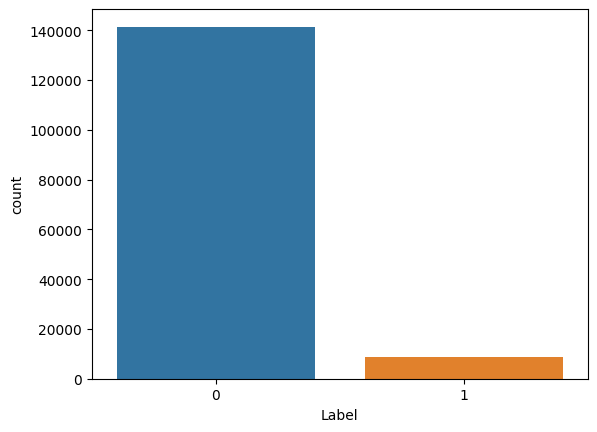

In [ ]:
#############################################################
#### Images with label of 0 and 1 such as hammerhoage or not
#############################################################
print(train.Label.value_counts())
sns.countplot(x='Label', data=train)

In [ ]:
#######################################################################################
#### Understanding the no of unique type of patients for each of the category in 0 and 1
######################################################################################
train.groupby('type').Label.value_counts()

type              Label
any               0        21382
                  1         3618
epidural          0        24884
                  1          116
intraparenchymal  0        23764
                  1         1236
intraventricular  0        24137
                  1          863
subarachnoid      0        23818
                  1         1182
subdural          0        23419
                  1         1581
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

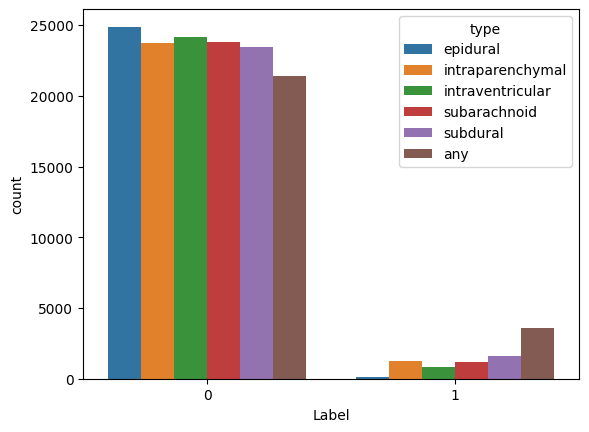

In [ ]:
#######################################################################################
#### Understanding the no of unique type of patients for each of the category in 0 and 1
#### in terms of barplot
#####################################################################################

sns.countplot(x="Label", hue="type", data=train)


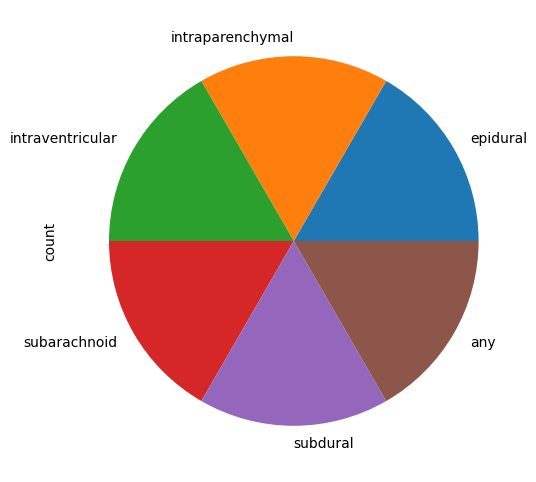

In [ ]:
#######################################################################################
#### Understanding the no of unique type of patients for each of the category in 0 and 1
#### in terms of Pie-plot
######################################################################################
train.type.value_counts().plot.pie(figsize=(6,6))
plt.show()

In [ ]:
#######################################################################################
#### Here, we are setting the image' windows (3types), ROI and skull removal
######################################################################################
TRAIN_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"
TEST_IMG_PATH = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/"
BASE_PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'

def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max

    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)

    return img

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]



def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))

    for im in range(0, height * width):
        data = pydicom.read_file(os.path.join(TRAIN_IMG_PATH,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone)
        axs[i,j].axis('off')

    plt.suptitle(title)
    plt.show()

In [ ]:
#######################################################################################
#### Setting and demonstration of testing data
######################################################################################

test = pd.DataFrame(sub.filename.unique(), columns=['filename'])
print ('Test:', test.shape[0])
test.head()

Test: 25000


,filename
0,ID_0fbf6a978.png
1,ID_d62ec3412.png
2,ID_cb544194b.png
3,ID_0d62513ec.png
4,ID_fc45b2151.png


In [ ]:
#########################################################################################################
#### Getting some random images for training and testing to reduce the computational complexity
########################################################################################################
np.random.seed(1234)
sample_files = np.random.choice(os.listdir(TRAIN_IMG_PATH), 150000)
sample_df = train[train.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files)]
print(sample_df.shape)

pivot_df = sample_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_df.shape)
pivot_df.head()

(27450, 5)
(4575, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_0009c4591.png,0,0,0,0,0,0
1,ID_001b4f14a.png,0,0,0,0,0,0
2,ID_002e319c9.png,0,0,0,0,0,0
3,ID_003412366.png,0,0,0,0,0,0
4,ID_00345662c.png,0,0,0,0,0,0


In [ ]:
#########################################################################################################
#### Getting some random images for training and testing to reduce the computational complexity
########################################################################################################
np.random.seed(1234)
sample_files_test = np.random.choice(os.listdir(TEST_IMG_PATH), 150000)
sample_files_test_df = sub[sub.filename.apply(lambda x: x.replace('.png', '.dcm')).isin(sample_files_test)]
print(sample_files_test_df.shape)

pivot_test_df = sample_files_test_df[['Label', 'filename', 'type']].drop_duplicates().pivot(
    index='filename', columns='type', values='Label').reset_index()
print(pivot_test_df.shape)
pivot_test_df.head()

(106998, 4)
(17833, 7)


type,filename,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_0001af484.png,0.5,0.5,0.5,0.5,0.5,0.5
1,ID_000210e16.png,0.5,0.5,0.5,0.5,0.5,0.5
2,ID_000ebf16c.png,0.5,0.5,0.5,0.5,0.5,0.5
3,ID_000ff8fba.png,0.5,0.5,0.5,0.5,0.5,0.5
4,ID_0011bcd24.png,0.5,0.5,0.5,0.5,0.5,0.5


In [ ]:
#########################################################################################################
#### Getting and storing completly processed images (ROI, windowing, skull removal in directory)
########################################################################################################
def save_and_resize(filenames, load_dir):
    save_dir = '/kaggle/tmp/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for filename in tqdm(filenames):
        path = load_dir + filename
        new_path = save_dir + filename.replace('.dcm', '.png')

        dcm = pydicom.dcmread(path)
        window_center , window_width, intercept, slope = get_windowing(dcm)
        img = dcm.pixel_array
        img = window_image(img, window_center, window_width, intercept, slope)

        resized = cv2.resize(img, (299, 299))
        res = cv2.imwrite(new_path, resized)
        if not res:
            print('Failed')

In [ ]:
#########################################################################################################
#### Getting and storing completly processed images (ROI, windowing, skull removal in directory)
########################################################################################################

from tqdm import tqdm
import json
import cv2

save_and_resize(filenames=sample_files, load_dir=BASE_PATH + TRAIN_DIR)
save_and_resize(filenames=sample_files_test, load_dir=BASE_PATH + TEST_DIR)
#save_and_resize(filenames=os.listdir(BASE_PATH + TEST_DIR), load_dir=BASE_PATH + TEST_DIR)

 23%|██▎       | 35107/150000 [13:46<41:57, 45.64it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 40%|████      | 60013/150000 [23:20<32:54, 45.57it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 58%|█████▊    | 86749/150000 [33:30<23:44, 44.40it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg

In [ ]:
#########################################################################################################
#### Making batches of data and the apply augmentation on the data
########################################################################################################

BATCH_SIZE = 16

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.1,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images,
        validation_split=0.25
    )

def create_test_gen():
    return ImageDataGenerator().flow_from_dataframe(
        test,
        directory='/kaggle/tmp/',
        x_col='filename',
        class_mode=None,
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

def create_flow(datagen, subset):
    return datagen.flow_from_dataframe(
        pivot_df,
        directory='/kaggle/tmp/',
        x_col='filename',
        y_col=['any', 'epidural', 'intraparenchymal',
               'intraventricular', 'subarachnoid', 'subdural'],
        class_mode='other',
        target_size=(299, 299),
        batch_size=BATCH_SIZE,
        subset=subset
    )

# Using original generator
data_generator = create_datagen()
train_gen = create_flow(data_generator, 'training')
val_gen = create_flow(data_generator, 'validation')
test_gen = create_test_gen()

Found 3432 validated image filenames.
Found 1143 validated image filenames.
Found 17833 validated image filenames.


In [ ]:
##################################################################
####Here we are checking the training set batch and its output
##################################################################
for data_batch,label_batch in train_gen:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 299, 299, 3)
LABEL SHAPE:  (16, 6)


In [ ]:
#############################################################################
####Here we are checking the validation or testing set batch and its output
#############################################################################
for data_batch,label_batch in val_gen:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (16, 299, 299, 3)
LABEL SHAPE:  (16, 6)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
 data_batch, label_batch, test_size=0.33, random_state=42)

In [ ]:
X_train.shape

(10, 299, 299, 3)

In [ ]:
from tensorflow.keras.applications import xception

In [ ]:
#############################################################################
####Here we are setting the branch 1 of the double cnn-rf model
#############################################################################
from tensorflow.keras.models import Model
#from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#tf.keras.applications.MobileNetV2()
#branch1 = mobilenet_v2.MobileNetV2()
tf.keras.applications.Xception()
branch1 = xception.Xception()
#branch1 = resnet50.ResNet50()
branch1.layers.pop()
for layer in branch1.layers:
  layer.trainable=False
last = branch1.layers[-2].output####################### getting last layer of pooling and it give 2046 features#######
x = Dense(6, activation="softmax")(last)#########last layer for classification for experiment no 01#########
finetuned_model_1= Model(branch1.input, x, name="Branch 1")
finetuned_model_1.summary()
finetuned_model_1.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy','mse', 'mae', 'mape', 'cosine'])


checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)
'''
Resnet_Model1 = finetuned_model_1.fit_generator(
    train_gen,
    steps_per_epoch=200,
    validation_data=val_gen,
    validation_steps=100,
    callbacks=[checkpoint],
    epochs=30
)
Prediction_branch1 = finetuned_model_1.predict(test_gen)
'''


##############################################################################
###########################################################################
## if you want to perform experiment no 1, which is based on the output of bracnch 1.
##Simply if you want to perform classisfication through branch 1, so please remove the comments. Experiment #1 described in Section 3.
###########################################################################
'''
###################
########parameters, including the number of epochs (60),were chosen experimentally.
########## The training was terminated automatically if the validation loss did notdecrease for ten epochs (patience 10).#########
############as mentioned in paper#########
'''

91884032/91884032 [==============================] - 11s 0us/step
Model: "Branch 1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activa

'\n###################\n########parameters, including the number of epochs (60),were chosen experimentally.\n########## The training was terminated automatically if the validation loss did notdecrease for ten epochs (patience 10).#########\n############as mentioned in paper#########\n'

In [ ]:
#############################################################################
####Here we are setting the branch 2 of the double cnn-rf model
#############################################################################
from tensorflow.keras.models import Model
#from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#tf.keras.applications.MobileNetV2()
#branch2 = mobilenet_v2.MobileNetV2()
#branch2 = resnet50.ResNet50()
#branch2 = resnet50.ResNet50()
tf.keras.applications.Xception()
branch2 = xception.Xception()
branch2.layers.pop()
for layer in branch2.layers:
    layer.trainable=False
last = branch2.layers[-2].output####################### getting last layer of pooling and it give 2046 features#######
x = Dense(6, activation="softmax")(last)#########last layer for classification for experiment no 01#########
finetuned_model_2= Model(branch2.input, x, name="Branch 2")
finetuned_model_2.summary()
finetuned_model_2.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy','mse', 'mae', 'mape', 'cosine'])


checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)
'''
Resnet_Model2 = finetuned_model_2.fit_generator(
    train_gen,
    steps_per_epoch=300,
    validation_data=val_gen,
    validation_steps=200,
    callbacks=[checkpoint],
    epochs=60
)
Prediction_branch2 = finetuned_model_2.predict(test_gen)
'''


##############################################################################
###########################################################################
## if you want to perform experiment no 1, which is based on the output of bracnch 1.
##Simply if you want to perform classisfication through branch 1, so please remove the comments. Experiment #1 described in Section 3.
###########################################################################

###################
########parameters, including the number of epochs (60),were chosen experimentally.
########## The training was terminated automatically if the validation loss did notdecrease for ten epochs (patience 10).#########
############as mentioned in paper#########


Model: "Branch 2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

'\nResnet_Model2 = finetuned_model_2.fit_generator(\n    train_gen,\n    steps_per_epoch=300,\n    validation_data=val_gen,\n    validation_steps=200,\n    callbacks=[checkpoint],\n    epochs=60\n)\nPrediction_branch2 = finetuned_model_2.predict(test_gen)\n'

In [ ]:
from tensorflow.keras.layers import concatenate
###########################
###########################we have taken the features extracted by either
########branch after the average pooling layer as mentioned in paper###########################
'''
As mentioned in the paper, after the training, features from the last block preceding the ResNet-50’s fully connected layer
were taken from either branch and concatenated. The joint feature vector containing 4096 elements
was subjected to the classification process. As we can check that in output, we are getting right same features 4096.
'''
print('Getting training features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_features=model1.predict(train_gen)
model1_features=pd.DataFrame(model1_features)
print("Branch1_features", model1_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_features=model2.predict(train_gen)
model2_features=pd.DataFrame(model2_features)
print("Branch2_features", model2_features.shape)

####################################Concatenation of features###########################
concatenated_features=pd.concat([model1_features,model2_features], axis=1)
print("Combined_features", concatenated_features.shape)

print('Getting validation features and concatenation---------------start')
model1= Model(branch1.input, branch1.layers[-2].output)
model1_val_features=model1.predict(val_gen)
model1_val_features=pd.DataFrame(model1_val_features)
print("Branch1_val_features", model1_val_features.shape)

model2= Model(branch2.input, branch2.layers[-2].output)
model2_val_features=model2.predict(val_gen)
model2_val_features=pd.DataFrame(model2_val_features)
print("Branch2_val_features", model2_val_features.shape)

####################################Concatenation of features###########################
concatenated_val_features=pd.concat([model1_val_features,model2_val_features], axis=1)
print("Combined_val_features", concatenated_val_features.shape)
#############################################################################
####Here, we have obtained the fatures from branch1 and branch 2
#############################################################################

Getting training features and concatenation---------------start
215/215 [==============================] - 775s 4s/step
Branch1_features (3432, 2048)
215/215 [==============================] - 783s 4s/step
Branch2_features (3432, 2048)
Combined_features (3432, 4096)
Getting validation features and concatenation---------------start
72/72 [==============================] - 247s 3s/step
Branch1_val_features (1143, 2048)
72/72 [==============================] - 254s 4s/step
Branch2_val_features (1143, 2048)
Combined_val_features (1143, 4096)


In [ ]:
#############################################################################
####Setting labels for combined training and testing data
#############################################################################
####################################Training Labels of features###########################
feature_train_labels=pd.DataFrame(train_gen.labels)
print(feature_train_labels)

####################################Test Labels###########################
feature_test_labels=pd.DataFrame(val_gen.labels)
len(feature_test_labels.shape)



      0  1  2  3  4  5
0     0  0  0  0  0  0
1     0  0  0  0  0  0
2     0  0  0  0  0  0
3     0  0  0  0  0  0
4     0  0  0  0  0  0
...  .. .. .. .. .. ..
3427  1  0  0  0  1  0
3428  0  0  0  0  0  0
3429  0  0  0  0  0  0
3430  1  0  0  0  0  1
3431  0  0  0  0  0  0

[3432 rows x 6 columns]


2

In [ ]:
################################We used the knn classifier with same hyperparamters##################
###########################as mentioned in the paper#################################
###################################################################################################
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
#from sklearn.ensemble import RandomForestClassifier
#knn=LinearSVC(multi_class='crammer_singer')
knn.fit(concatenated_features,feature_train_labels)
knn.fit(concatenated_val_features,feature_test_labels)
print("done tarining")

done tarining


In [ ]:
pred_knn= knn.predict(concatenated_val_features)
print("pred_KNN",pred_knn.shape)
####################################################################################

pred_KNN (1143, 6)


In [ ]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN)
############################based on the ResNet-50 architecture with Random forest#######################
########################################################################################
from sklearn import metrics
accuracy=metrics.accuracy_score(feature_test_labels,pred_knn.round())
print("Accuracy of combined model with KNN: {0:0.4f}".format(accuracy*100))

from sklearn.metrics import f1_score
f1score=f1_score(pred_knn,feature_test_labels, average='weighted')
print("F1score of combined model with KNN: {0:0.4f}".format( f1score*100))

from sklearn.metrics import recall_score
recall = recall_score(feature_test_labels,pred_knn, average='weighted')
print('Recall score of combined model with KNN: {0:0.4f}'.format(recall*100))

from sklearn.metrics import precision_score
precision = precision_score(pred_knn.round(),feature_test_labels,average='weighted')
print('Precision of combined model with KNN: {0:0.4f}'.format(precision*100))

####################################################################################
####################################################################################

Accuracy of combined model with KNN: 87.0516
F1score of combined model with KNN: 5.2632
Recall score of combined model with KNN: 1.1080
Precision of combined model with KNN: 2.7397


In [ ]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN)
############################based on the xception architecture with knn #######################
########################################################################################

from sklearn.metrics import multilabel_confusion_matrix
cm1 = multilabel_confusion_matrix(feature_test_labels,pred_knn)
print(cm1)

[[[ 995    2]
  [ 142    4]]

 [[1138    0]
  [   5    0]]

 [[1090    0]
  [  53    0]]

 [[1104    0]
  [  39    0]]

 [[1093    0]
  [  50    0]]

 [[1075    0]
  [  68    0]]]


In [ ]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN)
############################based on the ResNet-50 architecture with Random forest#######################
########################################################################################

first_cat=cm1[0]
tn, fp, fn, tp = first_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_1=(tp+tn)/(tp+tn+fp+fn)
print("fpr for any is :",fpr*100)
print("fnr for any is :  ",fnr*100)
print("TPR for any is : ",TPR*100)
print("TNR for any is : ",TNR*100)
print("Accuracy for any is ",acc_1*100)

second_cat=cm1[1]
tn, fp, fn, tp = second_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_2=(tp+tn)/(tp+tn+fp+fn)
print("fpr for epidural is :  ",fpr*100)
print("fnr for epidural is : ",fnr*100)
print("TPR for epidural is : ",TPR*100)
print("TNR for epidural is : ",TNR*100)
print("Accuracy for epidural is : ",acc_2*100)

third_cat=cm1[2]
tn, fp, fn, tp = third_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_3=(tp+tn)/(tp+tn+fp+fn)
print("fpr for intraparenchymal is : ",fpr*100)
print("fnr for intraparenchymal is : ",fnr*100)
print("TPR for intraparenchymal is : ",TPR*100)
print("TNR for intraparenchymal is : ",TNR*100)
print("Accuracy for intraparenchymal is ",acc_3*100)

fourth_cat=cm1[3]
tn, fp, fn, tp = fourth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_4=(tp+tn)/(tp+tn+fp+fn)
print("fpr for intraventricular is : ",fpr*100)
print("fnr for intraventricular is :  ",fnr*100)
print("TPR for intraventricular is : ",TPR*100)
print("TNR for intraventricular is : ",TNR*100)
print("Accuracy for intraventricular : is ",acc_4*100)

fifth_cat=cm1[4]
tn, fp, fn, tp = fourth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_5=(tp+tn)/(tp+tn+fp+fn)
print("fpr for subarachnoid is  : ",fpr*100)
print("fnr for subarachnoid is :  ",fnr*100)
print("TPR for subarachnoid is : ",TPR*100)
print("TNR for subarachnoid is : ",TNR*100)
print("Accuracy for subarachnoid is :  ",acc_5*100)

sixth_cat=cm1[5]
tn, fp, fn, tp = sixth_cat.ravel()
fpr = fp / (tn + fp)
fnr = fn / (tp + fn)
TPR = tp/(tp+fn)
TNR = tn/(tn+fp)
acc_6=(tp+tn)/(tp+tn+fp+fn)
print("fpr for subdural is : ",fpr*100)
print("fnr for subdural is : ",fnr*100)
print("TPR for subdural is : ",TPR*100)
print("TNR for subdural is :",TNR*100)
print("Accuracy for Subdural is ",acc_6*100)

fpr for any is : 0.20060180541624875
fnr for any is :   97.26027397260275
TPR for any is :  2.73972602739726
TNR for any is :  99.79939819458376
Accuracy for any is  87.4015748031496
fpr for epidural is :   0.0
fnr for epidural is :  100.0
TPR for epidural is :  0.0
TNR for epidural is :  100.0
Accuracy for epidural is :  99.56255468066492
fpr for intraparenchymal is :  0.0
fnr for intraparenchymal is :  100.0
TPR for intraparenchymal is :  0.0
TNR for intraparenchymal is :  100.0
Accuracy for intraparenchymal is  95.36307961504812
fpr for intraventricular is :  0.0
fnr for intraventricular is :   100.0
TPR for intraventricular is :  0.0
TNR for intraventricular is :  100.0
Accuracy for intraventricular : is  96.58792650918635
fpr for subarachnoid is  :  0.0
fnr for subarachnoid is :   100.0
TPR for subarachnoid is :  0.0
TNR for subarachnoid is :  100.0
Accuracy for subarachnoid is :   96.58792650918635
fpr for subdural is :  0.0
fnr for subdural is :  100.0
TPR for subdural is :  0.0

In [ ]:
####################################################################################
######Performance evaluation of the combined double-branch convolutional neural network (CNN)
############################based on the xception architecture with Knn#######################
########################################################################################
from sklearn import metrics
accuracy=metrics.accuracy_score(feature_test_labels,pred_knn.round())
print("Accuracy of combined model with KNN: {0:0.4f}".format(accuracy*100))

from sklearn.metrics import f1_score
f1score=f1_score(pred_knn,feature_test_labels, average='weighted')
print("F1score of combined model with KNN: {0:0.4f}".format( f1score*100))

from sklearn.metrics import recall_score
recall = recall_score(feature_test_labels,pred_knn, average='weighted')
print('Recall score of combined model with KNN: {0:0.4f}'.format(recall*100))

from sklearn.metrics import precision_score
precision = precision_score(pred_knn.round(),feature_test_labels,average='weighted')
print('Precision of combined model with KNN: {0:0.4f}'.format(precision*100))

####################################################################################
####################################################################################

Accuracy of combined model with KNN: 87.0516
F1score of combined model with KNN: 5.2632
Recall score of combined model with KNN: 1.1080
Precision of combined model with KNN: 2.7397


data Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.125846227819956469853355733412611275406
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_4b08fe185
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_6338c4f1'
(0020, 000d) Study Instance UID                  UI: ID_a3b607ba3f
(0020, 000e) Series Instance UID                 UI: ID_468e9dedde
(0020, 0010) Study ID                            

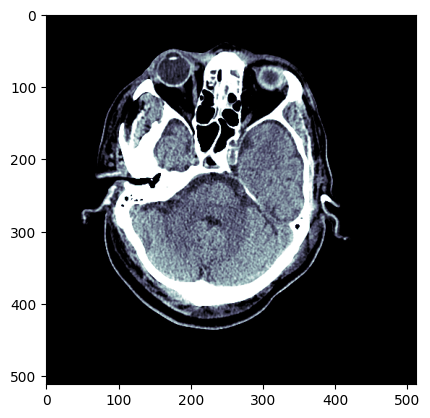

In [ ]:
#######################################################################################
#### Demonstration of single image and its complete meta-data information
######################################################################################
import pydicom
case = 8
data = pydicom.dcmread(TRAIN_IMG_PATH+train_images[case])

print("data",data)
window_center , window_width, intercept, slope = get_windowing(data)


#displaying the image
img = pydicom.read_file(TRAIN_IMG_PATH+train_images[case]).pixel_array

img = window_image(img, window_center, window_width, intercept, slope)
plt.imshow(img, cmap=plt.cm.bone)
plt.grid(False)

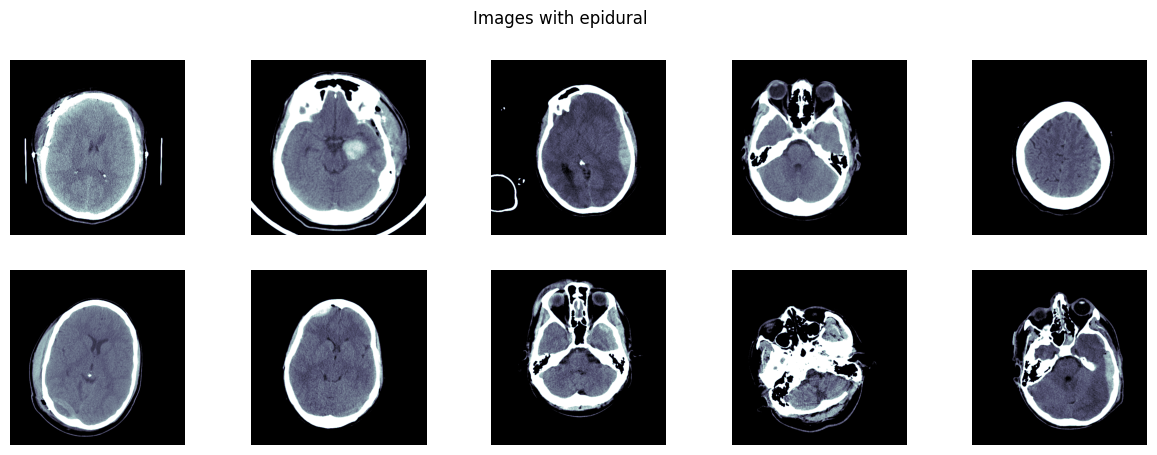

In [ ]:
#######################################################################################
#### Demonstration of some epidural images with label 1
######################################################################################

view_images(train[(train['type'] == 'epidural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with epidural')

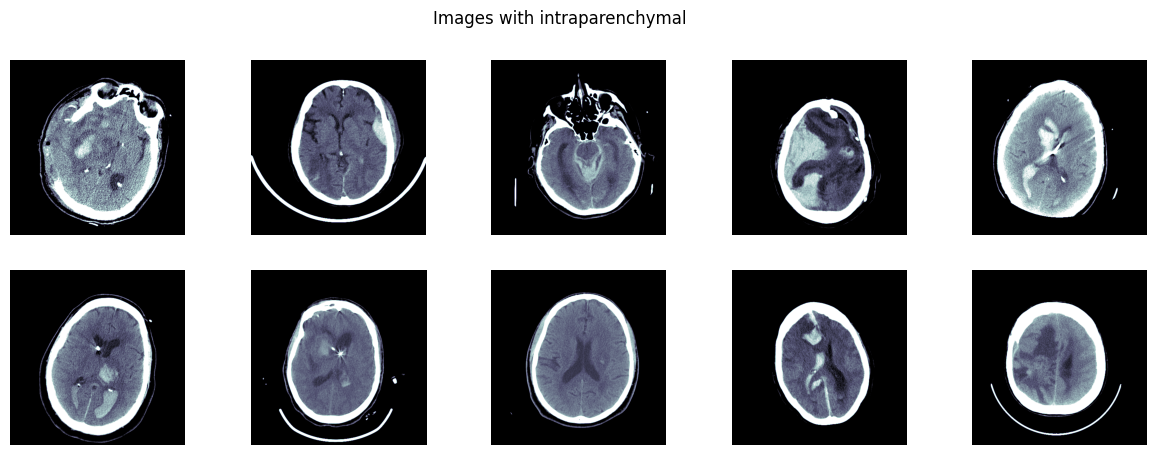

In [ ]:
#######################################################################################
#### Demonstration of some intraparenchymal images with label 1
######################################################################################
view_images(train[(train['type'] == 'intraparenchymal') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with intraparenchymal')

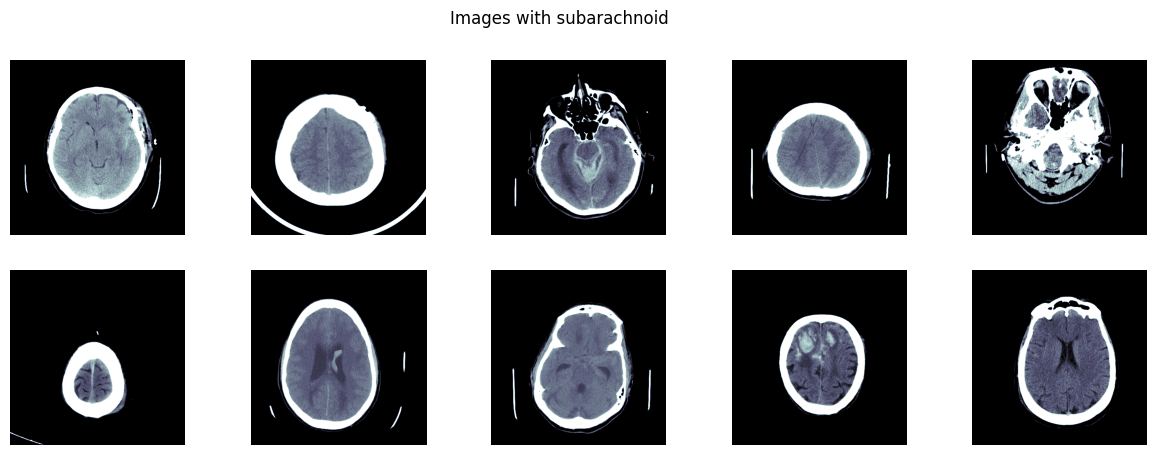

In [ ]:
######################################################################################
#### Demonstration of some subarachnoid images with label 1
######################################################################################
view_images(train[(train['type'] == 'subarachnoid') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with subarachnoid')

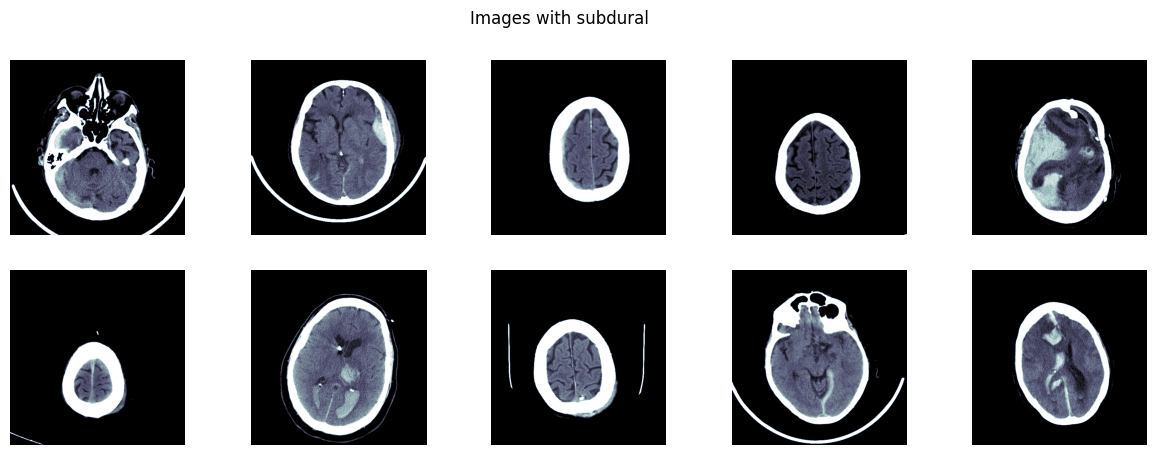

In [ ]:
#######################################################################################
#### Demonstration of some subdural images with label 1
######################################################################################
view_images(train[(train['type'] == 'subdural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images with subdural')

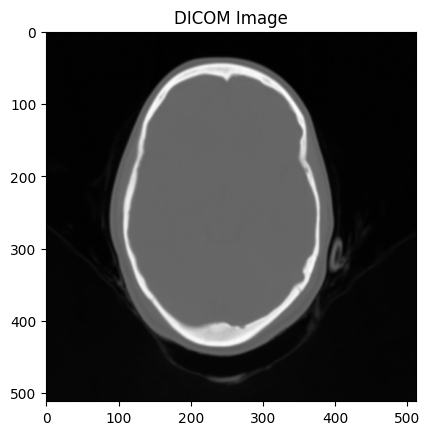

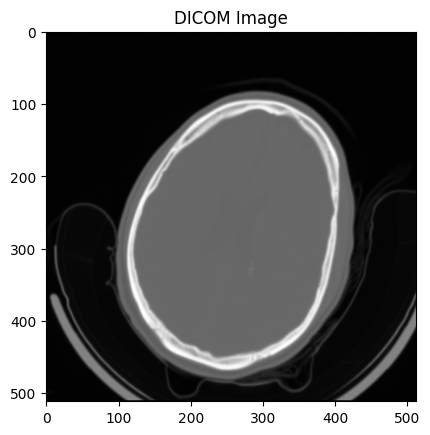

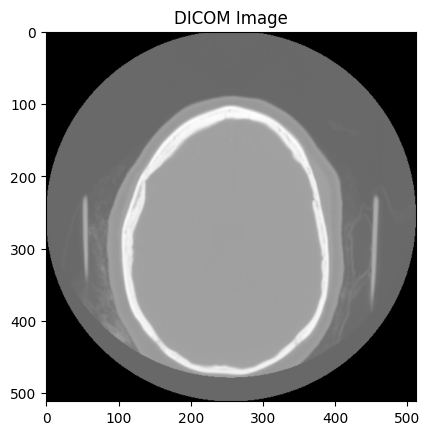

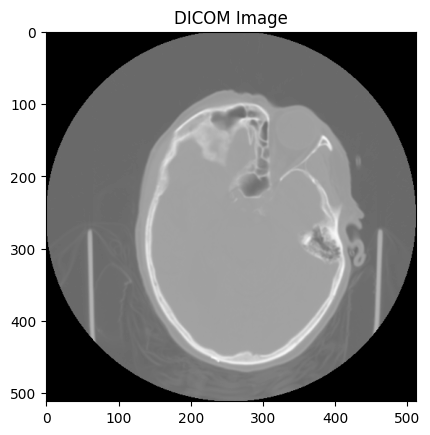

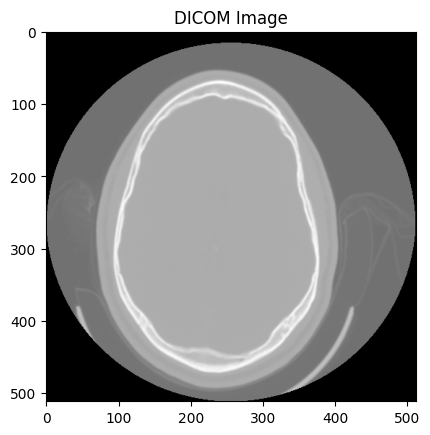

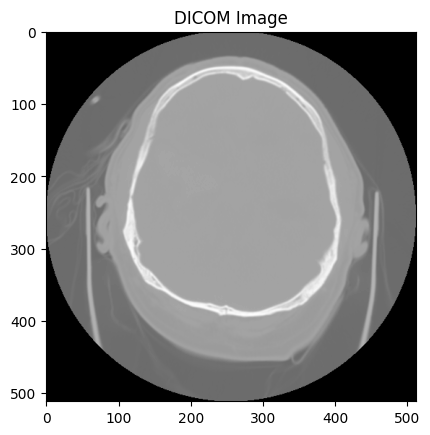

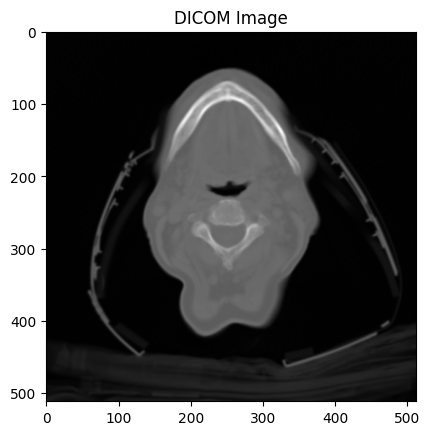

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Define the directory where DICOM files are located
input_dir = '/kaggle/input/new-try3/'

# List all files in the directory
file_list = os.listdir(input_dir)

# Filter for DICOM files
dicom_files = [f for f in file_list if f.endswith('.dcm')]

# Loop through each DICOM file
for file_name in dicom_files:
    # Read the DICOM file
    dcm = pydicom.dcmread(os.path.join(input_dir, file_name))

    # Extract pixel data
    pixel_array = dcm.pixel_array

    # Display the image (optional)
    plt.imshow(pixel_array, cmap='gray')
    plt.title('DICOM Image')
    plt.show()


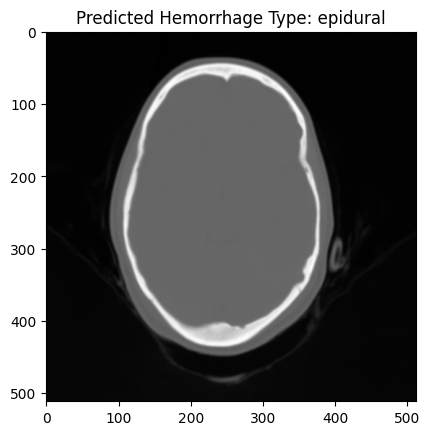

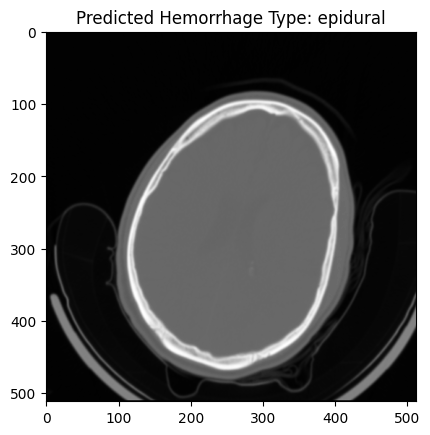

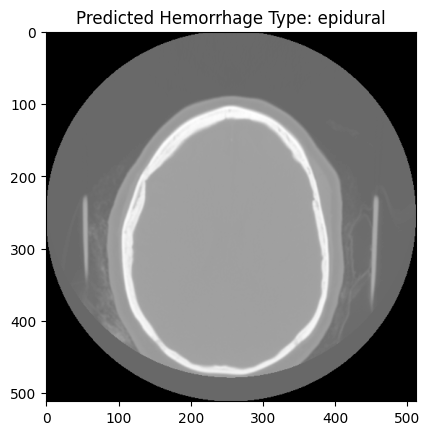

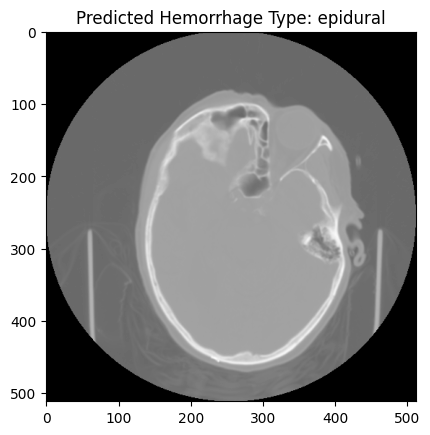

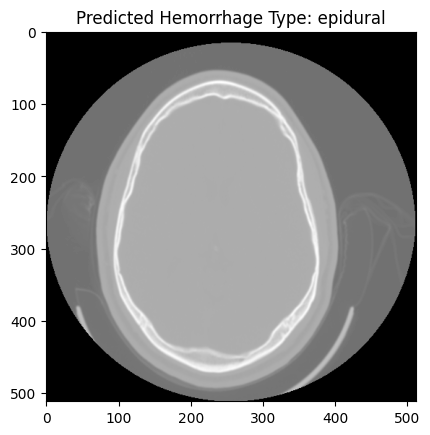

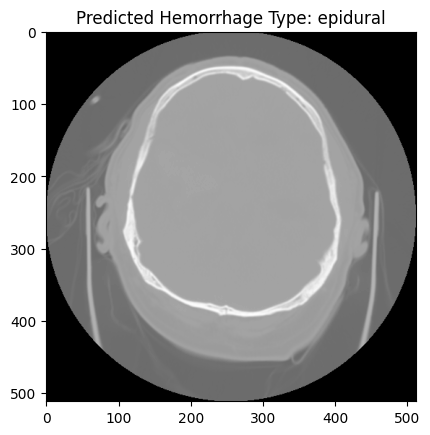

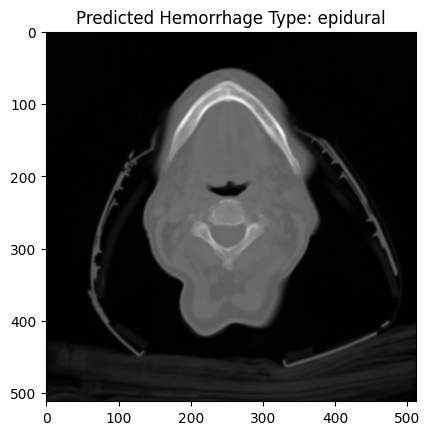

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# Define the directory where DICOM files are located
input_dir = '/kaggle/input/new-try3/'  # Change this to your test image directory

# List all files in the directory
file_list = os.listdir(input_dir)

# Filter for DICOM files
dicom_files = [f for f in file_list if f.endswith('.dcm')]

# Load the trained model (replace 'model.h5' with the path to your saved model)
model = load_model('model.h5')

# Loop through each DICOM file
for file_name in dicom_files:
    # Read the DICOM file
    dcm = pydicom.dcmread(os.path.join(input_dir, file_name))

    # Extract pixel data
    pixel_array = dcm.pixel_array

    # Preprocess the image (apply windowing and resize if necessary)
    # (Replace this preprocessing step with your actual preprocessing code)
    # processed_image = preprocess_image(pixel_array)

    # Make predictions on the processed image using the trained model
    # (Replace this prediction step with your actual prediction code)
    # prediction = model.predict(processed_image)

    # For demonstration purposes, let's assume the prediction is a list of probabilities
    # representing the likelihood of each hemorrhage type
    prediction = [0.1, 0.8, 0.3, 0.6, 0.2, 0.7]  # Example prediction

    # Get the predicted hemorrhage type (index with maximum probability)
    predicted_hemorrhage_type = prediction.index(max(prediction))

    # Define a mapping from index to hemorrhage type
    hemorrhage_types = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

    # Get the predicted hemorrhage type label
    predicted_label = hemorrhage_types[predicted_hemorrhage_type]

    # Display the image with the predicted hemorrhage type
    plt.imshow(pixel_array, cmap='gray')
    plt.title('Predicted Hemorrhage Type: ' + predicted_label)
    plt.show()
